# E9_나의 첫 번째 캐글 경진대회

**튜닝해볼 수 있는 모델 클래스 인자**  
대표적으로 자주 튜닝하는 **lightgbm 라이브러리의 인자**는 다음과 같습니다.

* **max_depth** : 의사 결정 나무의 깊이, 정수 사용
* **learning_rate** : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
* **n_estimators** : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
* **num_leaves** : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
* **boosting_type** : 부스팅 방식, gbdt, rf 등의 문자열 입력

**시도해볼 수 있는 방법**  
여러분이 시도해볼 수 있는 방법은 다음과 같은 것들이 있습니다.

* 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (**피처 엔지니어링**)
* **LGBMRegressor, XGBRegressor, RandomForestRegressor** 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
* 다양한 하이퍼 파라미터에 대해 **그리드 탐색**을 시도해서 최적의 조합을 찾아보기
* Baseline 커널에서 활용했던 **블렌딩 방법** 활용하기

**루브릭** 

|평가문항|	상세기준|
|:-------------|:---------|
|1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?|데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.|
|2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?|제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.|
|3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?|다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.|

## 0. 필요한 라이브러리 불러오기

In [62]:
# 시각화 그래프 위해서
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [63]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

## 1. 데이터 살펴보기

[캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/data)  

pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도 (적도 기준)
19. long : 경도 (북극, 남극 연결선)
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### 1-1. 데이터 불러오기

In [64]:
# 로컬에서 사용할 때 파일 경로
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

# 데이터 경로 지정하기
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')  

# 데이터 불러오기
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(f'train data dim : {train.shape}')
print(f'test data dim : {test.shape}')

train data dim : (15035, 21)
test data dim : (6468, 20)


In [65]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [66]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 1-2. date 컬럼 처리
date 변수는 연월일시간으로 스트링 값을 가지고 있는데, 정수형 데이터(int)로 처리해보겠습니다.   
이렇게 하면 모델이 date도 예측을 위한 특성으로 활용할 수 있겠죠!

In [67]:
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)
test['date'] = test['date'].apply(lambda x: str(x[:6])).astype(int)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


**`str(x[:6])`** :  숫자를 문자열로 변환시키는 함수(str(x))로 x값에서 앞에서부터 6자리만 반환

**`.apply(lambda x : str(x[:6]))`** :  `train['date']`에서 한 행씩 읽어서 x로 하고 str()함수에 대입

**`.astype(int)`** :  데이터프레임에서 칼럼의 문자열을 (정수)숫자형으로 바꾸기


### 1-3. 가격과 상광 관계

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode' 'date']


<AxesSubplot:>

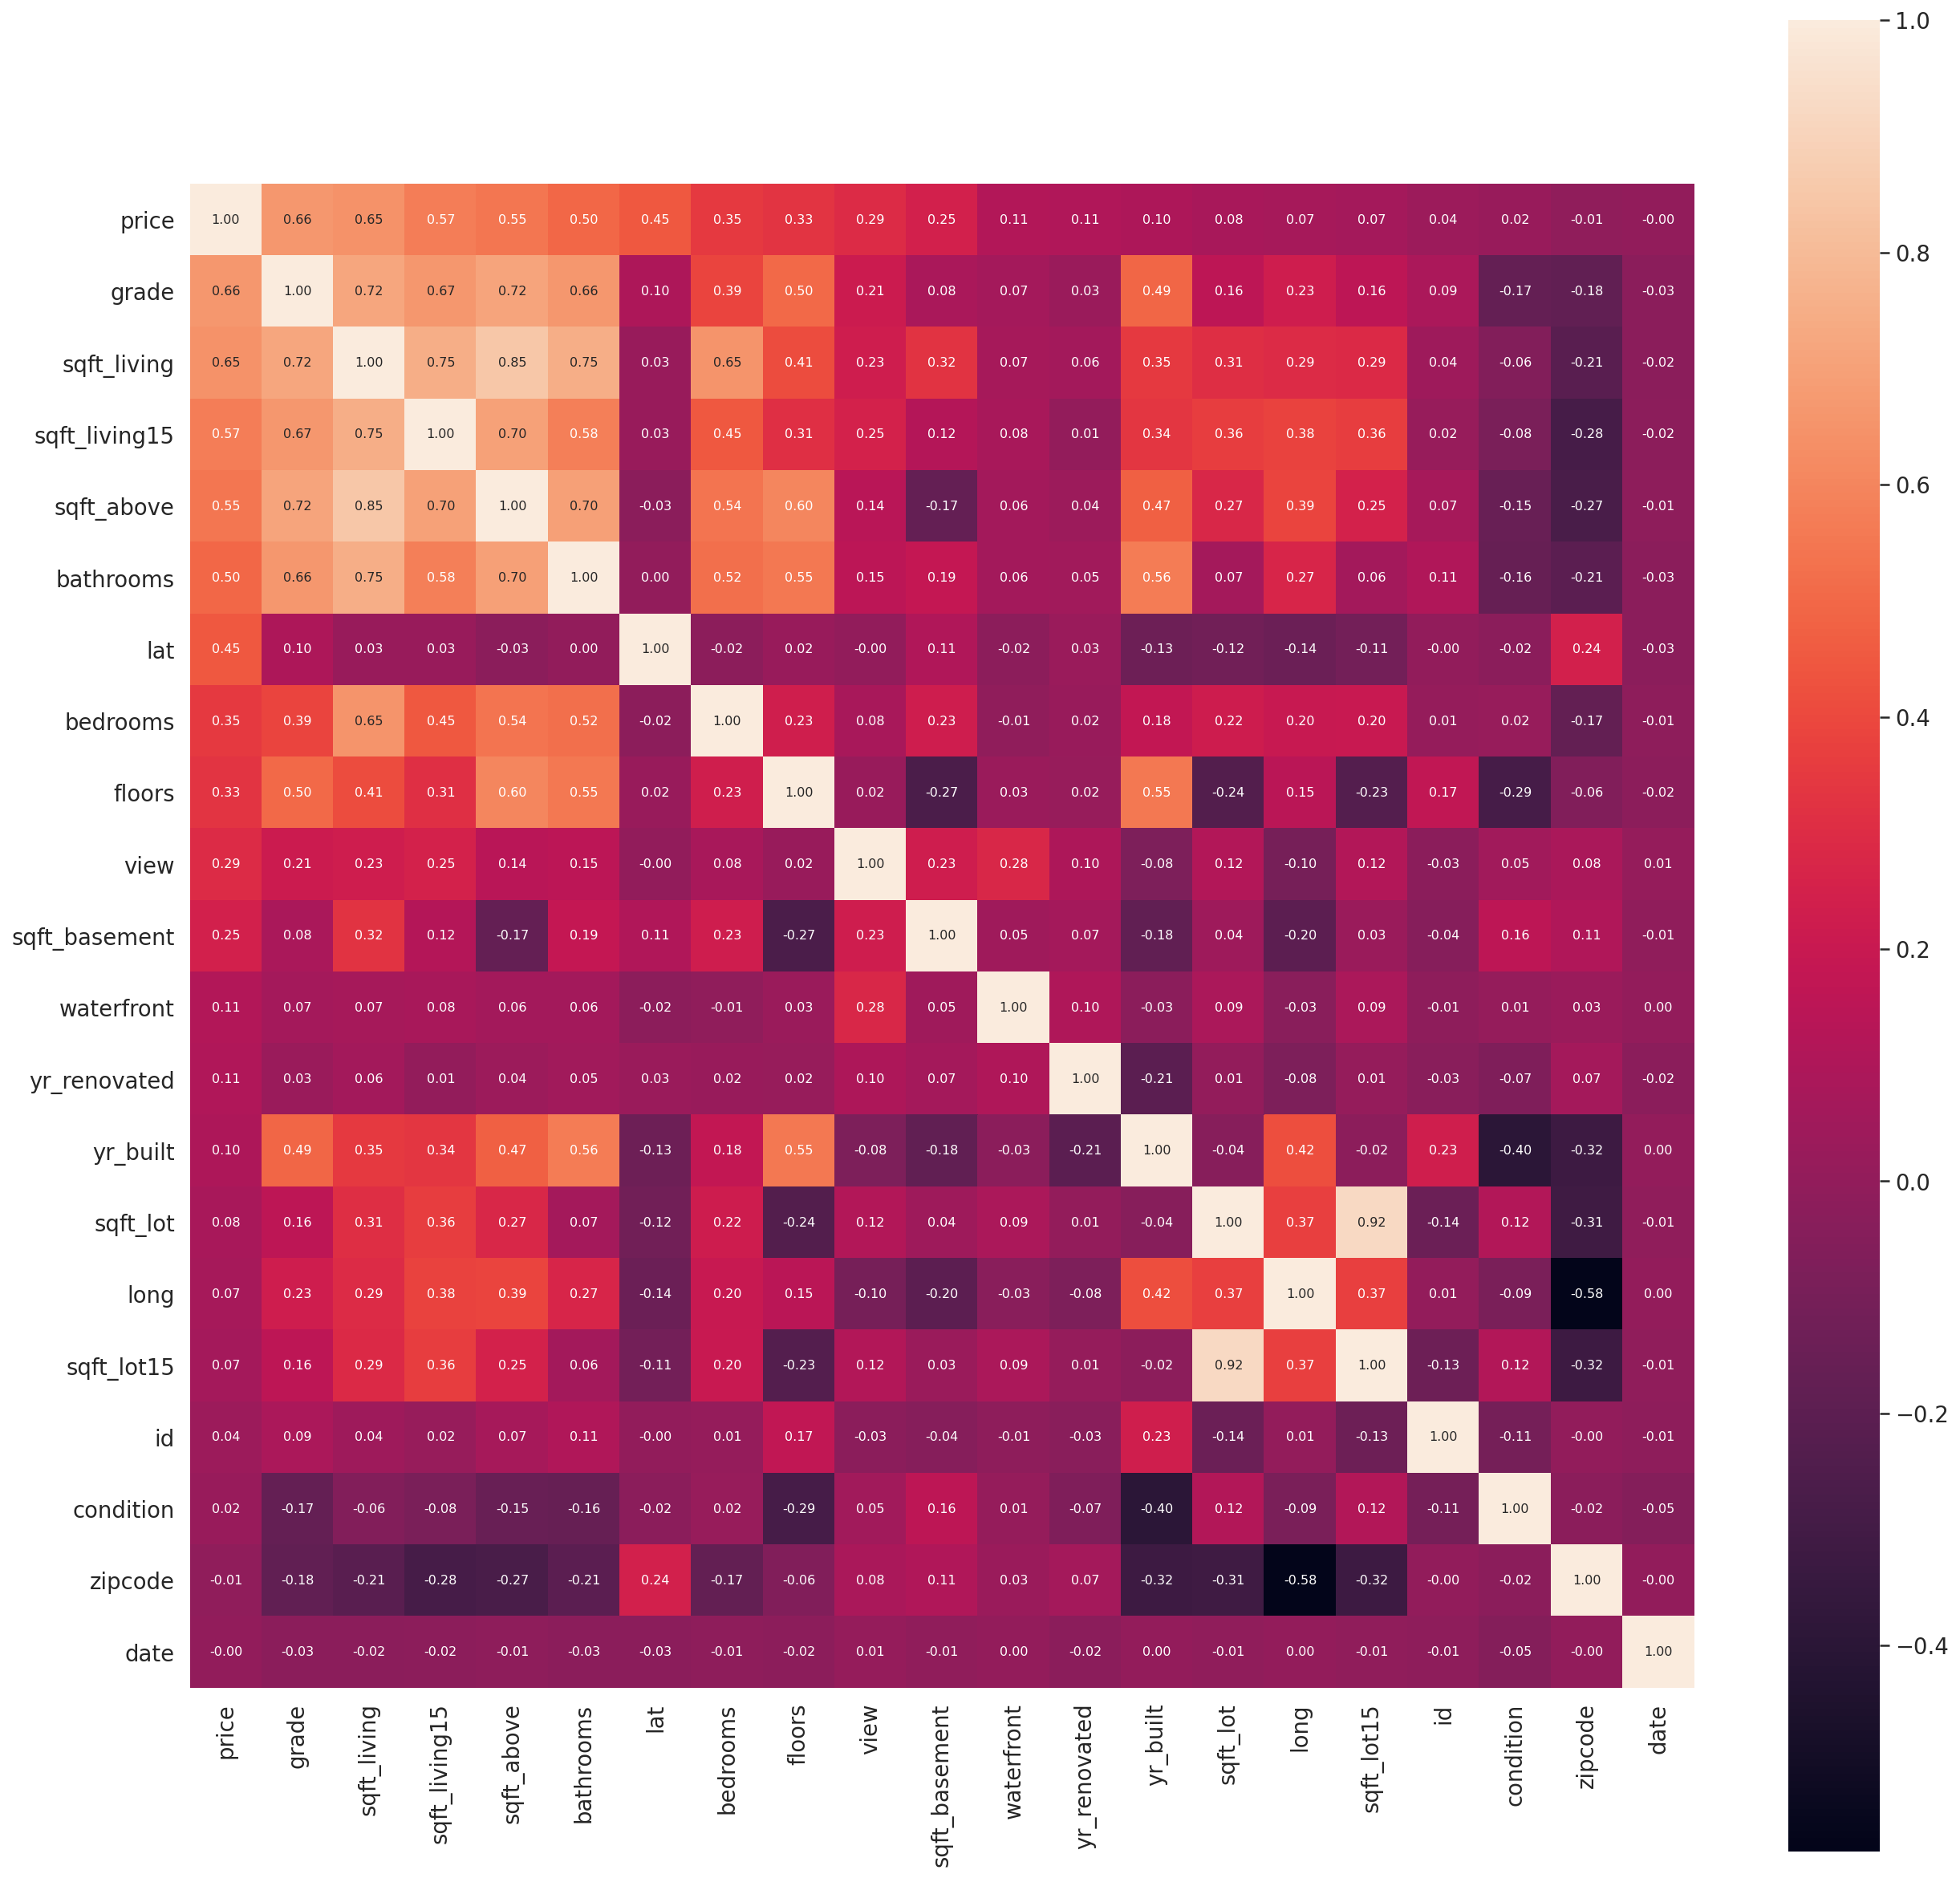

In [68]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)

plt.figure(figsize=(21,21))
sns.set(font_scale=1.25)
sns.heatmap(cor, 
            fmt='.2f', 
            annot=True, 
            square=True , 
            annot_kws={'size' : 8} ,
            xticklabels=cor_cols.values, 
            yticklabels=cor_cols.values)

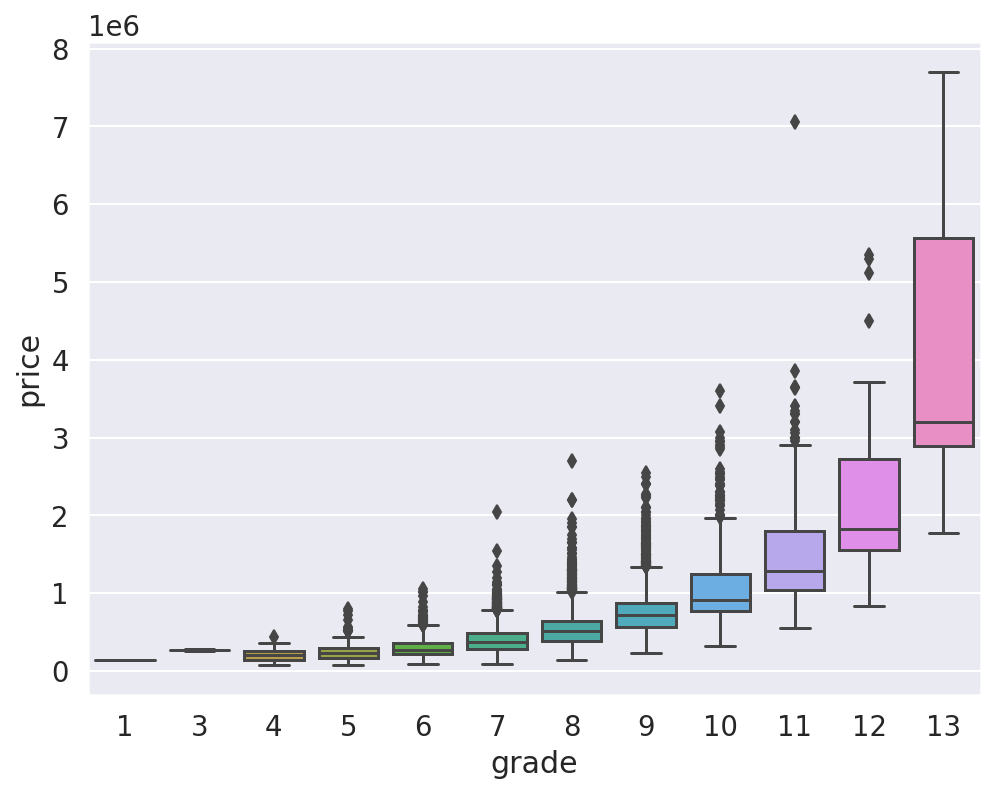

In [69]:
# 상관도가 가장 높은 집의 등급과 가격 그래프로 확인
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

## 2. 데이터 전처
### 2-1. 이상치 제거
상관관계가 높은 변수들에 대해서 시각화하여 이상치 있는지 확인

#### 2-1-1. grade 컬럼

In [70]:
train.loc[(train['price']>6*1E6) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [71]:
train.loc[(train['bedrooms']== 5) & (train['grade'] == 11)]['price'].mean()

1703331.1594202898

In [72]:
train.loc[(train['price']>5*1E6) & (train['grade'] == 12)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
842,842,201410,5110800.0,5,5.25,8010,45517,2.0,1,4,...,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
947,947,201504,5300000.0,6,6.00,7390,24829,2.0,1,4,...,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1045,1045,201504,5350000.0,5,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750


In [73]:
train.loc[(train['price']>2.5*1E6) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,201408,2700000.0,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [74]:
train.loc[(train['price']>2.0*1E6) & (train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,201501,2050000.0,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [75]:
# 이상치 데이터 삭제
train = train.drop([842, 947, 1045, 7173, 12346])

#### 2-1-2. sqft_living 컬럼

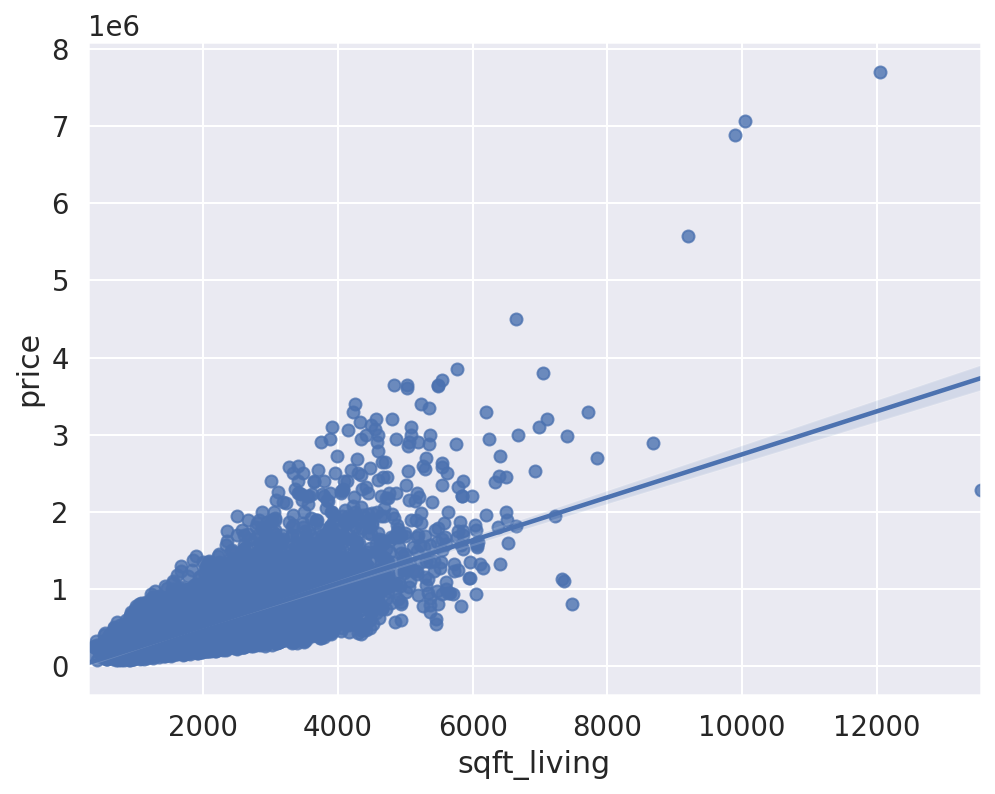

In [76]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [77]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [78]:
train.loc[(train['bedrooms']== 7) & (train['grade'] >= 10)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
411,411,201406,1950000.0,7,3.50,4640,15235,2.0,0,1,...,11,2860,1780,1965,2003,98040,47.5666,-122.231,3230,20697
2859,2859,201410,800000.0,7,6.75,7480,41664,2.0,0,2,...,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190
8912,8912,201405,2280000.0,7,8.00,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
9772,9772,201409,2885000.0,7,3.00,5350,14400,2.5,0,0,...,10,5020,330,1910,0,98112,47.6295,-122.285,3050,7469
10476,10476,201409,2450000.0,7,4.25,4670,23115,2.0,0,2,...,11,4670,0,1992,0,98039,47.6183,-122.227,3240,13912


In [79]:
# 이상치 데이터 삭제
train = train.drop([8912], axis=0)

#### 2-1-3. sqft_living15 컬럼

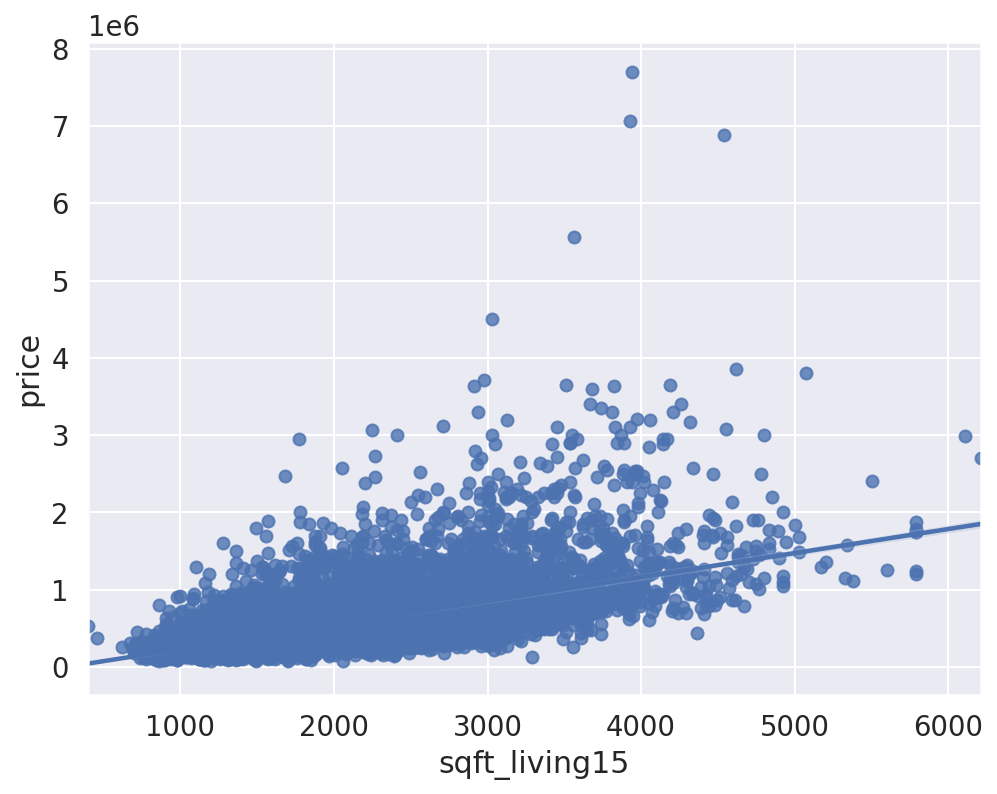

In [80]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

In [81]:
train.loc[train['price'] > 6*1E6]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
5108,5108,201410,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [82]:
train.loc[(train['bedrooms'] >= 5) & (train['grade'] >= 11) & (train['sqft_above'] > 7000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
5108,5108,201410,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
12921,12921,201407,1135250.0,5,4.00,7320,217800,2.0,0,0,...,11,7320,0,1992,0,98058,47.4473,-122.086,3270,34500


In [83]:
# 이상치 데이터 삭제
train = train.drop([2775, 5108, 6469], axis=0)

#### 2-1-4. sqft_above 컬럼

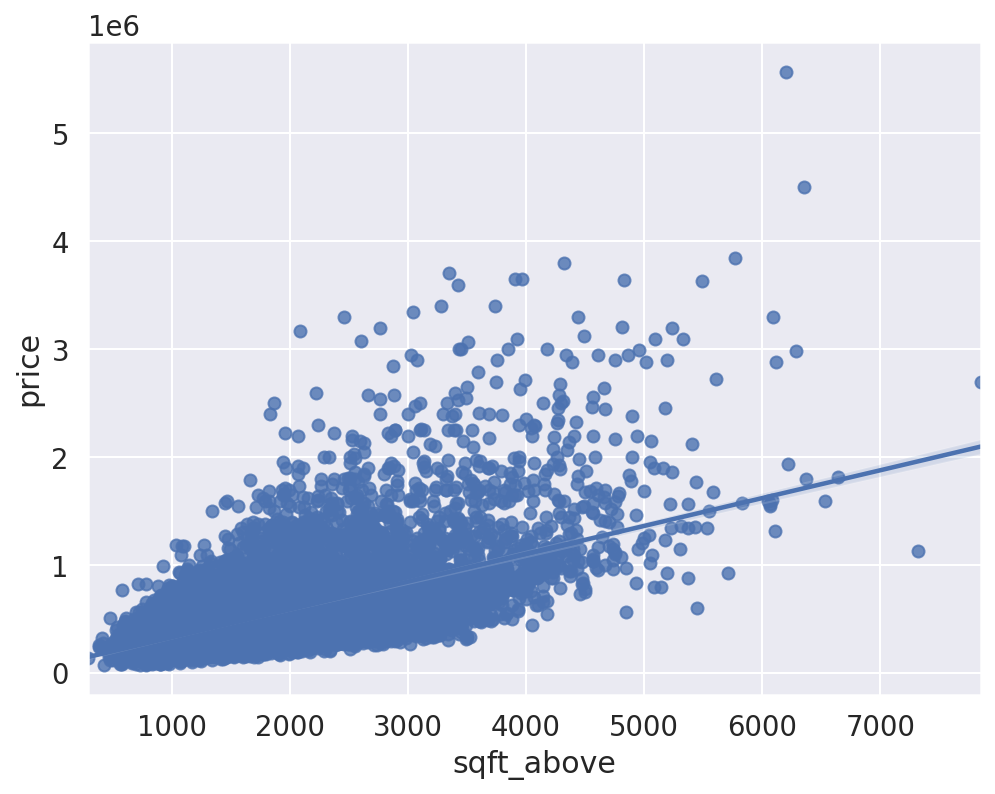

In [84]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

In [85]:
train.loc[train['sqft_above'] > 7000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12921,12921,201407,1135250.0,5,4.0,7320,217800,2.0,0,0,...,11,7320,0,1992,0,98058,47.4473,-122.086,3270,34500
13809,13809,201501,2700000.0,4,4.0,7850,89651,2.0,0,0,...,12,7850,0,2006,0,98027,47.5406,-121.982,6210,95832


In [86]:
# 이상치 데이터 삭제
train = train.drop([12921, 13809], axis=0)

#### 2-1-5. bathrooms 컬럼

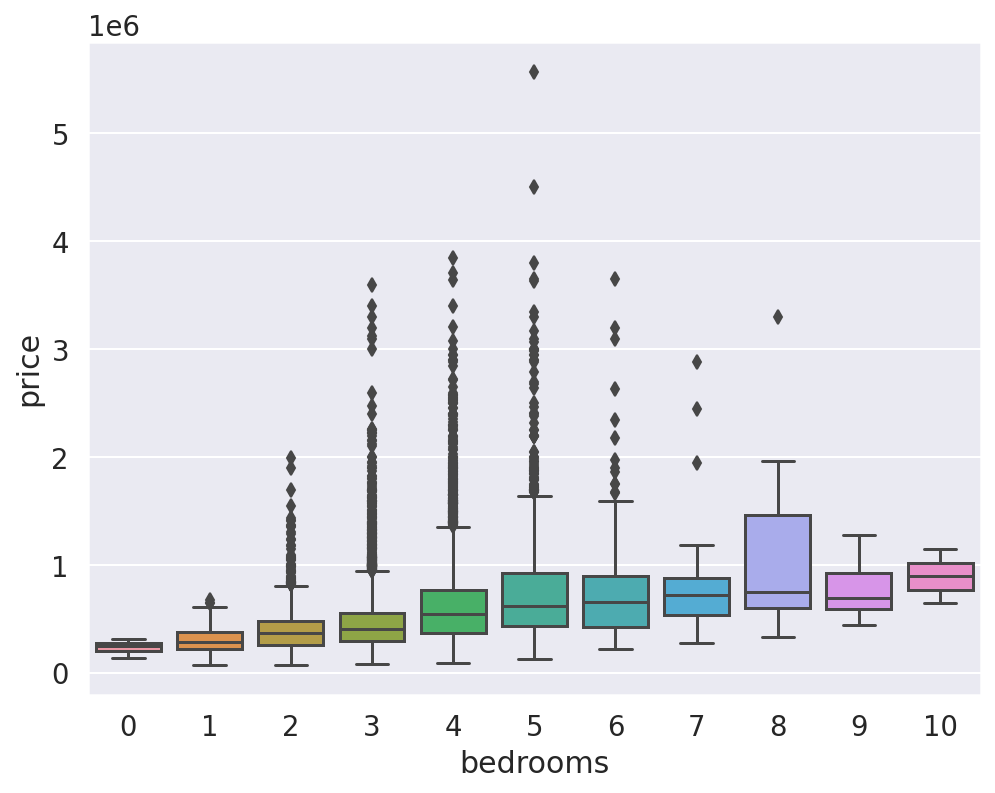

In [87]:
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [88]:
train.loc[(train['price']>4.0*1E6) & (train['bedrooms'] == 5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1882,1882,201408,4500000.0,5,5.50,6640,40014,2.0,1,4,...,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
3134,3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345


In [89]:
train.loc[(train['bedrooms'] == 5) & (train['grade'] >= 12)& (train['bathrooms'] >= 5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1882,1882,201408,4500000.0,5,5.50,6640,40014,2.0,1,4,...,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
3134,3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
4957,4957,201407,3800000.0,5,5.50,7050,42840,1.0,0,2,...,13,4320,2730,1978,0,98004,47.6229,-122.220,5070,20570
7246,7246,201412,2983000.0,5,5.50,7400,18898,2.0,0,3,...,13,6290,1110,2001,0,98006,47.5431,-122.112,6110,26442
10152,10152,201406,2888000.0,5,6.25,8670,64033,2.0,0,4,...,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021
11805,11805,201407,3100000.0,5,5.25,5090,23669,2.0,0,0,...,12,5090,0,2006,0,98004,47.6297,-122.216,3830,22605
13311,13311,201410,3635000.0,5,6.00,5490,19897,2.0,0,0,...,12,5490,0,2005,0,98039,47.6165,-122.236,2910,17600


In [90]:
train.loc[(train['price']>3.0*1E6) & (train['bedrooms'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12845,12845,201410,3300000.0,8,4.0,7710,11750,3.5,0,0,...,12,6090,1620,1904,0,98112,47.6263,-122.314,4210,8325


In [91]:
train.loc[(train['bedrooms'] >= 7) & (train['grade'] >= 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
411,411,201406,1950000.0,7,3.50,4640,15235,2.0,0,1,...,11,2860,1780,1965,2003,98040,47.5666,-122.231,3230,20697
2859,2859,201410,800000.0,7,6.75,7480,41664,2.0,0,2,...,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190
10476,10476,201409,2450000.0,7,4.25,4670,23115,2.0,0,2,...,11,4670,0,1992,0,98039,47.6183,-122.227,3240,13912
12845,12845,201410,3300000.0,8,4.00,7710,11750,3.5,0,0,...,12,6090,1620,1904,0,98112,47.6263,-122.314,4210,8325


In [92]:
# 이상치 데이터 삭제
train = train.drop([1882, 3134], axis=0)

In [93]:
# 이상치 제거 후 데이터 개수
print(len(train))  

# 15035 - 15022 = 12개 감소

15022


### 2-2. 정규화

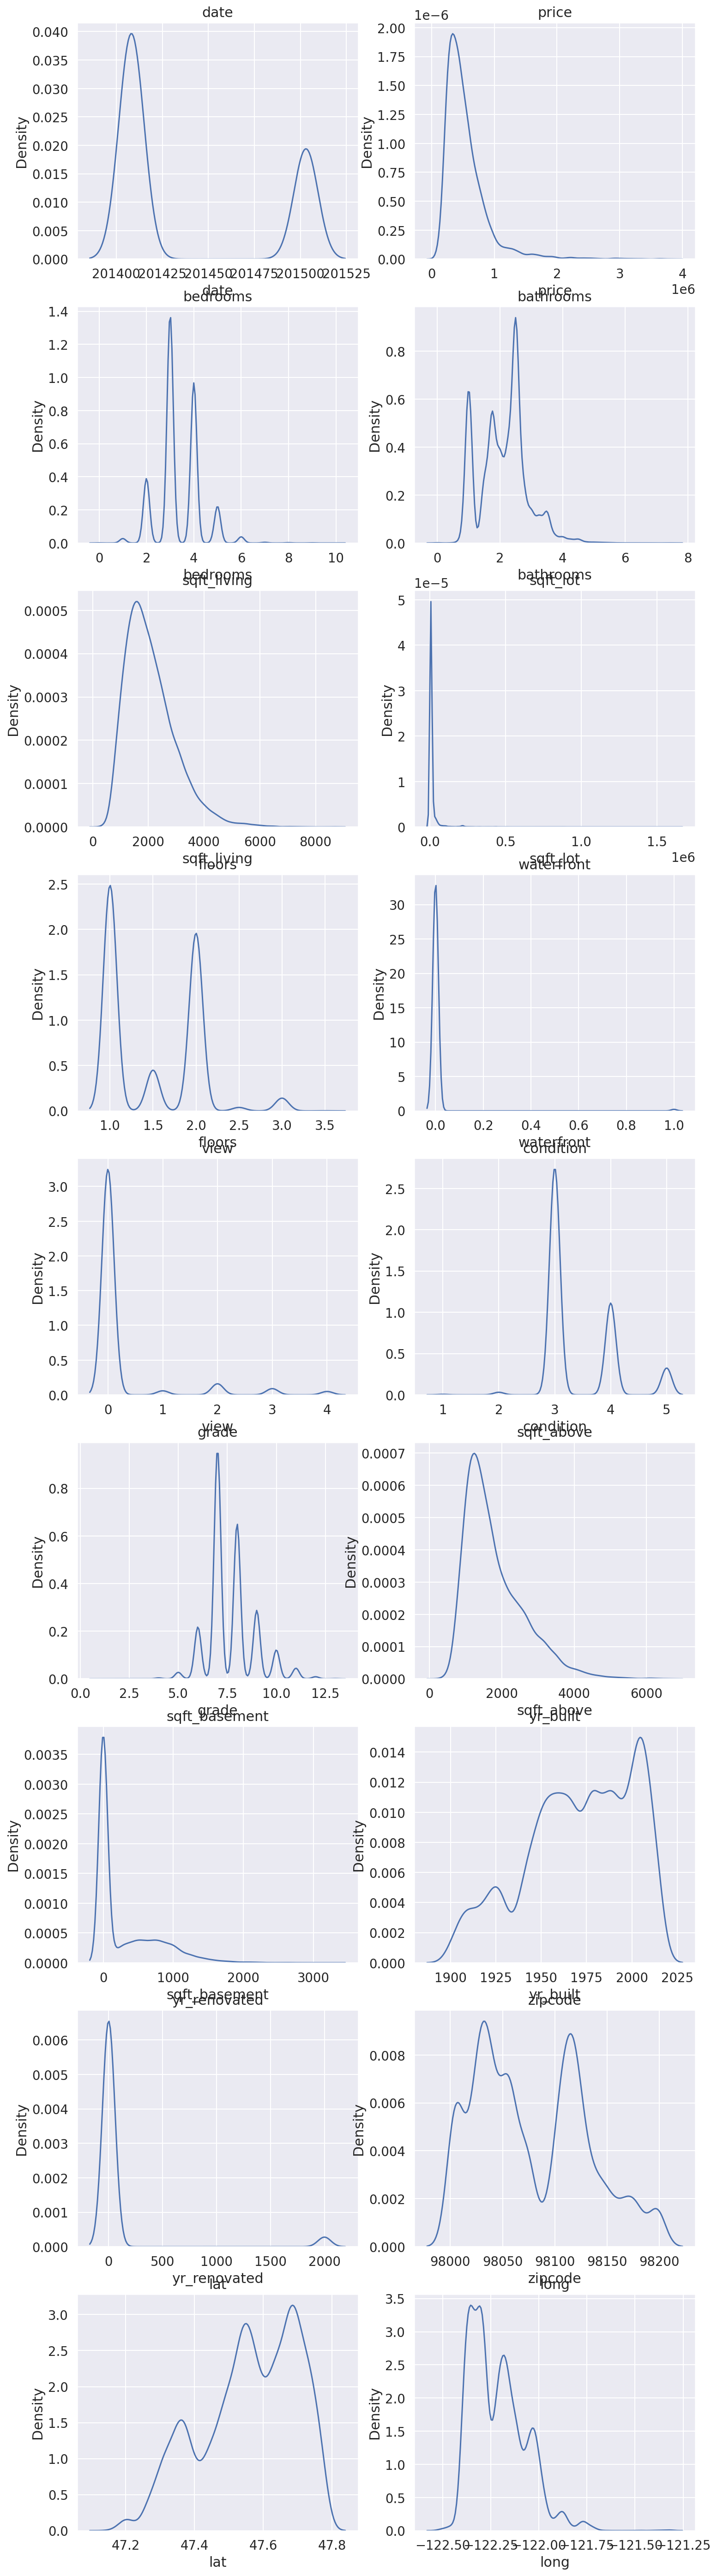

In [94]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다. (19 - 1 = 18 columns)
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

In [95]:
# 한쪽을 치우친 데이터 분포 경향이 있는 컬럼
skew_columns = [ 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

# 정규분포에 가깝게 만들기
for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

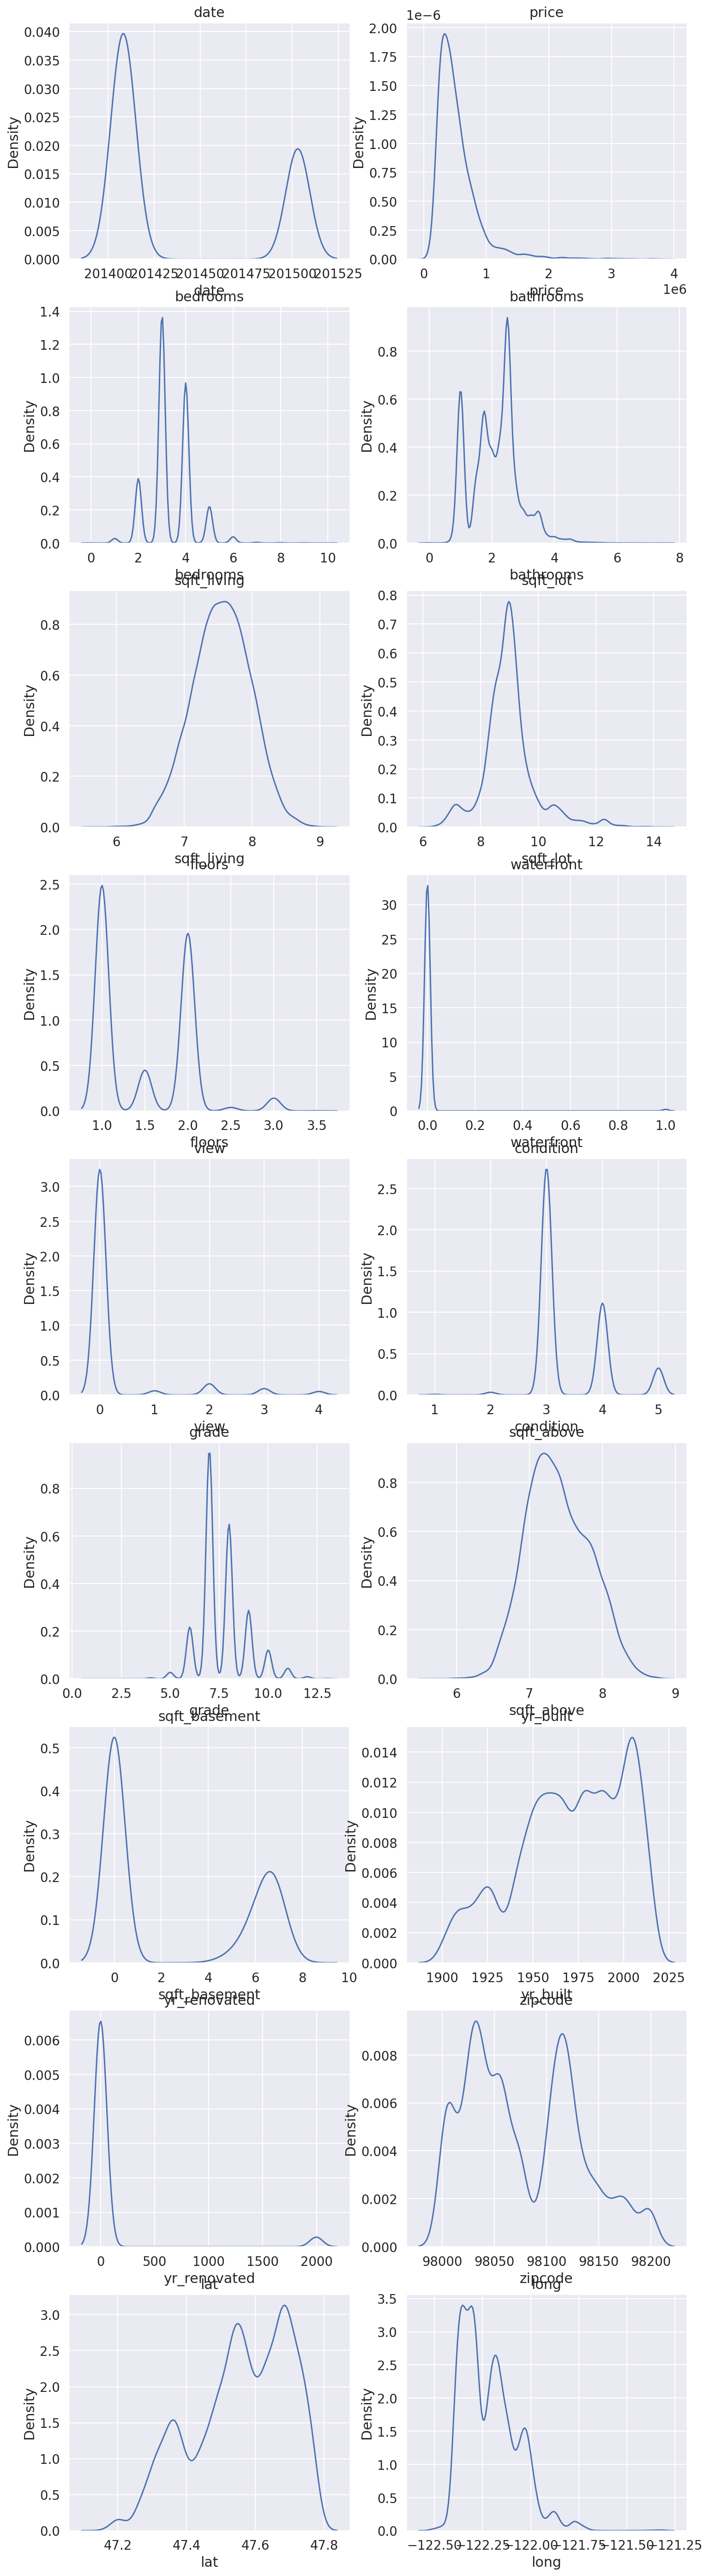

In [96]:
# 데이터 변환 후 분포 확인
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

### 2-3. 새로운 변수 생성

In [97]:
for df in [train, test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)


In [98]:
# # 평당 집값
# train['per_price'] = train['price']/train['sqft_total_size']

# # 근처 지역 평당 집값의 평균과 분산
# zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()

# train = pd.merge(train, zipcode_price, how='left', on='zipcode')
# test = pd.merge(test, zipcode_price, how='left', on='zipcode')

# for df in [train, test]:
#     df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
#     df['zipcode_var'] = df['var'] * df['sqft_total_size']
    
#     del df['mean'] 
#     del df['var']

In [99]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated
0,0,201410,221900.0,3,1.00,7.074117,8.639588,1.0,0,0,...,47.5112,-122.257,7.201171,8.639588,4.00,0.818803,7.074117,1.0,0.833509,1
1,1,201502,180000.0,2,1.00,6.647688,9.210440,1.0,0,0,...,47.7379,-122.233,7.908755,8.995041,3.00,0.721756,6.647688,1.0,0.879235,1
2,2,201502,510000.0,3,2.00,7.427144,8.997271,1.0,0,0,...,47.6168,-122.045,7.496097,8.923191,5.00,0.825489,7.427144,1.0,0.840069,1
3,3,201406,257500.0,3,2.25,7.447751,8.827615,2.0,0,0,...,47.3097,-122.327,7.713785,8.827615,5.25,0.843688,7.447751,1.0,0.873824,1
4,4,201501,291850.0,3,1.50,6.966967,9.181118,1.0,0,0,...,47.4095,-122.315,7.409136,9.181118,4.50,0.758837,6.966967,1.0,0.806997,1


In [100]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated
0,15035,201412,3,2.25,7.852050,8.887791,2.0,0,0,3,...,47.7210,-122.319,7.433075,8.941153,5.25,0.883465,13.676905,0.574110,0.831333,1
1,15036,201412,4,3.00,7.581210,8.517393,1.0,0,0,5,...,47.5208,-122.393,7.215975,8.517393,7.00,0.890086,13.772040,0.550478,0.847205,1
2,15037,201405,4,4.50,8.598036,11.532051,1.0,0,0,3,...,47.6561,-122.005,8.468213,11.532051,8.50,0.745577,15.600098,0.551153,0.734320,1
3,15038,201504,3,1.00,7.484930,8.918784,1.0,0,0,3,...,47.5123,-122.337,7.484930,9.001346,4.00,0.839232,13.551911,0.552315,0.831535,1
4,15039,201503,3,2.50,7.544861,8.788898,2.0,0,0,3,...,47.3684,-122.031,7.779467,8.932080,5.50,0.858454,7.544861,1.000000,0.870958,1


### 2-4. 학습 데이터에서 라벨 (price) 제거하기
**price 컬럼**은 따로 y라는 변수에 저장한 후 해당 컬럼은 지워줍니다.

In [101]:
# 맞춰야하는 값
y = train['price']

# price 칼럼 삭제
del train['price']

### 2-5. 도움 되지 않는 변수 정리
* **id 컬럼**은 모델이 집값을 예측하는데 도움을 주지 않으므로 제거
* 집값과 변수들의 상관 관계에서 'id' 컬럼보다 작은 값을 갖는 것은 제거
  - **id 컬럼**
  - **condition 컬럼**
  - **zipcode 컬럼**
  - **date 컬럼**

In [102]:
# 'id', 'condition', 'zipcode', 'date' 칼럼 삭제
train = train.drop(['id', 'condition', 'zipcode', 'date'], axis=1)
test = test.drop(['id', 'condition', 'zipcode', 'date'], axis=1)

In [103]:
print('train 피쳐 갯수 :',len(train.columns))
print(train.columns)
print('test 피쳐 갯수 :',len(test.columns))
print(test.columns)

train 피쳐 갯수 : 22
Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'total_rooms', 'sqft_ratio', 'sqft_total_size',
       'sqft_ratio_1', 'sqft_ratio15', 'is_renovated'],
      dtype='object')
test 피쳐 갯수 : 22
Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'total_rooms', 'sqft_ratio', 'sqft_total_size',
       'sqft_ratio_1', 'sqft_ratio15', 'is_renovated'],
      dtype='object')


### 2-6. 타겟 데이터 정규화

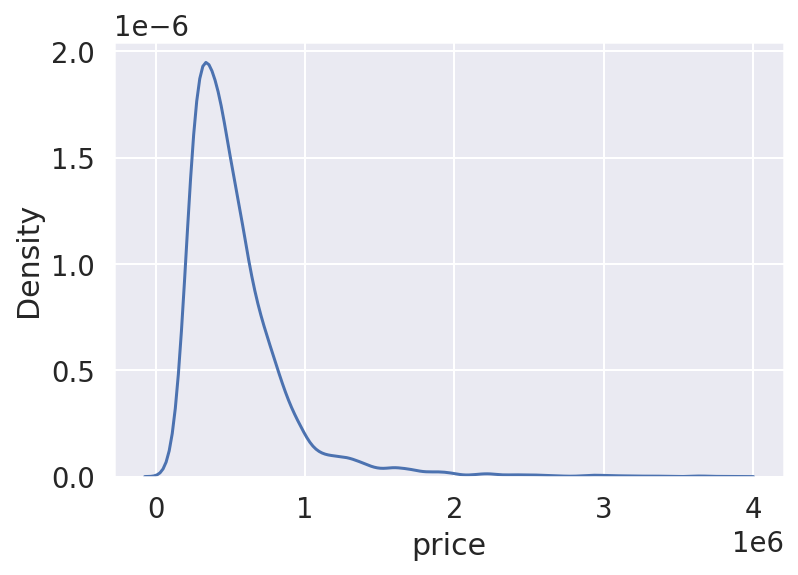

In [104]:
# 우리가 맞추어야 할 타겟인 집의 가격 데이터 분포
sns.kdeplot(y)
plt.show()

<span style='color:blue'>**커널 밀도 추정(KDE: Kernel Density Estimator) 그래프** :</span>
  - 히스토그램 같은 분포를 부드럽게 곡선화 시켜서 그려줌
  - **`sns.kdeplot(data=dataset1, shade=True)`**
    - data: pandas의 DataFrame, 파이썬의 list, numpy의 배열 등 시각화시키고 싶은 데이터 세트
    - shade: 곡선 아래의 공간을 음영 처리할지 결정 (True/False)

In [105]:
# 한쪽으로 치우친 분포의 'price' 데이터에 대해서 로그 변환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15022, dtype: float64

* **np.log1p()** 함수를 통해 y는 로그 변환을 해주고, 
  - 나중에 모델이 값을 예측한 후에 다시 **np.exp1m()** 을 활용해서 되돌리겠습니다.   
    
    
* **np.exp1m()** 은 np.log1p()과는 반대로 각 원소 x마다 **exp(x)-1의 값을 반환**해 줍니다.

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15022, dtype: float64

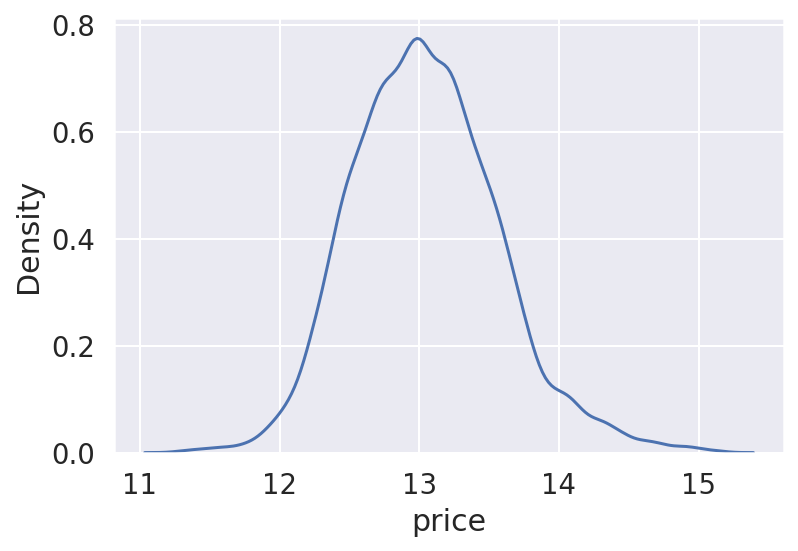

In [106]:
# 가격 데이터의 로그 변환 후 분포 그리기
sns.kdeplot(y)
y

price 데이터 분포는 정규분포의 형상을 띄는 방향으로 변환됨

* 모두 실수 또는 정수 자료형으로, 문제없이 모델 학습에 활용할 수 있을 것 같습니다.

### 2-7. 결측치 확인

In [107]:
# train 데이터에서 결측치 확인
train[train.isnull().any(axis=1)]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated


In [108]:
# test 데이터에서 결측치 확인
test[test.isnull().any(axis=1)]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated


* **isnull()** 함수는 판다스 데이터프레임 및 시리즈의 **결측치(NaN)를 탐색**해 결측치에 대해 True를 반환
* **axis=1**은 **열에 대해 적용**하라는 뜻이므로, 결측치(NaN)가 존재하는 열을 확인

### 2-8. 중복 데이터 확인

In [109]:
train[train.duplicated()]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated
9677,3,1.00,6.908755,8.846209,1.0,0,0,7,6.908755,0.0,...,47.7142,-122.319,6.908755,8.846209,4.00,0.780985,6.908755,1.0,0.780985,1
14089,2,2.25,7.384610,7.585281,2.0,0,0,7,7.384610,0.0,...,47.5184,-122.196,7.576097,7.585281,4.25,0.973545,7.384610,1.0,0.998789,1


In [110]:
test[test.duplicated()]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated


### 2-9. 데이터의 자료형 확인

In [111]:
# 전체 데이터의 자료형을 한눈에 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15022 entries, 0 to 15034
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         15022 non-null  int64  
 1   bathrooms        15022 non-null  float64
 2   sqft_living      15022 non-null  float64
 3   sqft_lot         15022 non-null  float64
 4   floors           15022 non-null  float64
 5   waterfront       15022 non-null  int64  
 6   view             15022 non-null  int64  
 7   grade            15022 non-null  int64  
 8   sqft_above       15022 non-null  float64
 9   sqft_basement    15022 non-null  float64
 10  yr_built         15022 non-null  int64  
 11  yr_renovated     15022 non-null  int64  
 12  lat              15022 non-null  float64
 13  long             15022 non-null  float64
 14  sqft_living15    15022 non-null  float64
 15  sqft_lot15       15022 non-null  float64
 16  total_rooms      15022 non-null  float64
 17  sqft_ratio  

## 3. 다양한 실험을 위한 함수 생성

### 3-1. RMSE 계산

In [52]:
from sklearn.model_selection import train_test_split  # 데이터 셋을 나누기 위해서
from sklearn.metrics import mean_squared_error        # RMSE 점수 계산을 위해서

* 대회에서 점수를 매기는 것과 같은 평가 척도인 **RMSE**를 계산하기 위해 다음과 같은 함수를 만들어놓겠습니다.  
* 한 가지 주의해야 할 것은, **y_test나 y_pred**는 위에서 **np.log1p()** 로 변환이 된 값이기 때문에   
* 원래 데이터의 단위에 맞게 되돌리기 위해 **np.expm1()** 을 추가해야 한다는 점입니다.

* exp로 다시 변환해서 **mean_squared_error**를 계산한 값에 **np.sqrt**를 취하면 **RMSE** 값을 얻을 수 있겠죠!

In [54]:
# 평가 척도인 RMSE를 계산하기 위한 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 3-2. 4가지 모델 생성
**XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor**  
모델 인스턴스를 생성한 후 **models**라는 리스트에 넣어줍니다.  

In [55]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [56]:
random_state=2020        

gboost   = GradientBoostingRegressor(random_state=random_state)
xgboost  = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [57]:
# 각 모델의 이름은 클래스의 __name__ 속성에 접근해서 얻을 수 있습니다.
gboost.__class__.__name__

'GradientBoostingRegressor'

### 3-3. 각 모델 별로 학습 및 예측

In [58]:
# 네 가지의 모델에 대해 모두 RMSE값을 얻을 수 있는 함수
def get_scores(models, train, y):
        df = {}

        for model in models:
            # 모델 이름 획득
            model_name = model.__class__.__name__

            # train, valid 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
            X_train, X_valid, y_train, y_valid = train_test_split(train, 
                                                                  y, 
                                                                  random_state=random_state, 
                                                                  test_size=0.2)

            # 모델 학습
            model.fit(X_train, y_train)

            # 예측
            y_pred = model.predict(X_valid)

            # 예측 결과의 rmse값 저장
            df[model_name] = rmse(y_valid, y_pred)

            # data frame에 저장
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)
        
        return score_df

get_scores(models, train, y)

,RMSE
LGBMRegressor,116990.946755
XGBRegressor,123426.584129
RandomForestRegressor,129763.863253
GradientBoostingRegressor,134480.832689


## 4. 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색
실험은 **sklearn.model_selection 라이브러리** 안에 있는 **GridSearchCV 클래스**를 활용합니다.  
  
**GridSearchCV**에 입력되는 인자들은 다음과 같습니다.

* **param_grid** : 탐색할 파라미터의 종류 (딕셔너리로 입력)
* **scoring** : 모델의 성능을 평가할 지표
* **cv** : **cross validation**을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
* **verbose** : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
* **n_jobs** : 그리드 탐색을 진행하면서 사용할 CPU의 개수

### 4-1. 그리드 탐색을 위한 파라미터와 모델 설정 

In [59]:
from sklearn.model_selection import GridSearchCV

**GridSearchCV**를 이용해서 **grid_model** 모델을 **초기화**하고,   
**train과 y 데이터**로 모델을 간단히 **학습**시키면   
**param_grid** 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

### 4-4. 그리드 탐색을 수행하는 함수 구현

In [60]:
# 그리드 탐색을 수행하는 함수 구현
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 `model`을 초기화
    grid_model = GridSearchCV(model, 
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5, 
                              verbose=verbose, 
                              n_jobs=n_jobs)

    # 모델을 fitting 
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 결과를 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임을 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값을 추가한 후 점수가 높은 순서로 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by="RMSLE")
    
    # `results`를 반환
    return results

### 4-1. 그리드 탐색 수행하기

In [117]:
# 만들어놓은 my_GridSearch() 함수로 간단한 그리드 탐색을 해보기
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 6, 7, 8],
}

model = LGBMRegressor(random_state=random_state)

my_GridSearch(model, 
              train, y, 
              param_grid, 
              verbose=2, 
              n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    6.8s finished


,max_depth,n_estimators,score,RMSLE
4,6,300,-0.028581,0.169058
6,7,200,-0.028619,0.169172
3,6,200,-0.028636,0.169221
5,6,400,-0.028658,0.169288
9,8,200,-0.028659,0.169288
10,8,300,-0.028667,0.169313
7,7,300,-0.028673,0.169330
8,7,400,-0.028814,0.169747
11,8,400,-0.028851,0.169856
2,5,400,-0.029065,0.170483


* 'n_estimators' : 학습 횟수
* 'max_depth' : 한 트리의 최대 깊이(디폴트는 6, 최대는 64)

In [118]:
# 가장 RMSLE 값이 작은 조건의 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출하기
model = LGBMRegressor(max_depth=6, n_estimators=300, random_state=random_state)

model.fit(train, y)

prediction = model.predict(test)

prediction

array([13.17722112, 13.05801525, 14.26471094, ..., 13.08724107,
       12.65604215, 12.98201189])

In [119]:
# 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌기
prediction = np.expm1(prediction)
prediction

array([ 528194.16190518,  468838.25601919, 1567057.63164733, ...,
        482742.66213828,  313651.87172596,  434525.35869496])

## 5. 캐글에 제출하기

### 5-1. 캐글 제출 파일 수정하기

In [122]:
# 제출 파일 생성하는 함수
def save_submission(model, train, y, test, model_name, rmsle):
    # 모델을 `train`, `y`로 학습시키기
    model.fit(train, y)

    # `test`에 대해 예측하기
    prediction = model.predict(test)
    
    # 예측값을 `np.expm1`으로 변환하기
    prediction = np.expm1(prediction)
    
    # sample_submission.csv 파일을 가져오기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path) 
    
    # 모델이 예측한 값으로 덮어씌우기
    submission['price'] = prediction
    
    # `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장하기
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 5-. 캐글 제출 하기

In [123]:
# 이 함수를 사용한다면 다음 한 줄로 모델을 학습시킨 후 예측 결과를 저장할 수 있습니다.
save_submission(model, train, y, test, 'lgbm', rmsle='0.169058')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/home/aiffel-d34j/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.169058.csv saved!


Score : 122152.39123  
캐글 랭킹 : 307 등

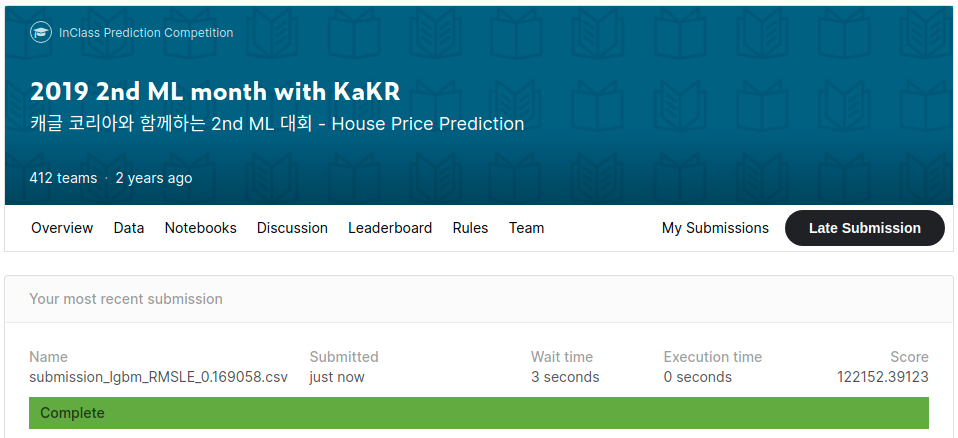

## 회고
1. Pandas 에서 DataFrame 열을 삭제하는 다양한 방법
  * del 방법
  * df.drop 메소드
  * df.pop 메소드
  

2. 커널 밀도 추정(KDE: Kernel Density Estimator) 그래프 그리기
  - 히스토그램 같은 분포를 부드럽게 곡선화 시켜서 그려줌
  - `sns.kdeplot(data=dataset1, shade=True)`
  - 데이터의 분포를 보고 싶다면 일단 seaborn으로 KDE plot을 그려보자


3. 통계 데이터의 해석을 위해서 많은 공부가 필요하다는 것을 느꼈다.
  - 데이터 전처리 한 다음에 이상치 판단할 때
  - 데이터의 피쳐끼리 상관 관계를 파악할 때
